<a href="https://colab.research.google.com/github/m-mehabadi/grad-maker/blob/main/_notebooks/Testing_GradientMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/dual-ascent.pdf

https://web.stanford.edu/class/ee364b/lectures/primal_dual_subgrad_slides.pdf

https://www.cvxpy.org/examples/basic/quadratic_program.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [2]:
def gmaker(grads, epochs = 100, method="simple", start="zero", verbose=1):
    lr = 0.01
    n, d = grads.shape
    w = np.random.randn(d) if start=="normal" else np.zeros(d)
    max_count = 0
    max_w = None
    for e in range(epochs):
        ge = grads[e%n]
        w_new = w + lr * (1. - (ge@w > 0)) * ge
        # w = w_new/np.linalg.norm(w_new)
        w = w_new if method=="simple" else w_new/np.linalg.norm(w_new)
        pos_count = np.sum(grads@w>0)
        max_count = pos_count if pos_count >= max_count else max_count
        max_w = w if pos_count >= max_count else max_w
        # if pos_count >= max_count:
        #     max_count = pos_count
    if verbose > 0:
        print(f"For {epochs} epochs: {pos_count} out of {n}, and maximum of {max_count}")
    total_count = n
    return w, (pos_count, max_count, total_count)

def gmaker_torch(grads, epochs = 100, method="simple", start="zero", verbose=1, device=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device
    lr = 0.01
    n, d = grads.size()
    w = torch.randn(d) if start=="normal" else torch.zeros(d)
    w = w.to(device)
    max_count = 0
    for e in range(epochs):
        ge = grads[e%n]
        w_new = w + lr * (1. - (ge@w > 0).int()) * ge
        # w = w_new/np.linalg.norm(w_new)
        w = w_new if method=="simple" else w_new/torch.norm(w_new)
        pos_count = torch.sum(grads@w>=0)
        max_count = pos_count if pos_count >= max_count else max_count
        # if pos_count >= max_count:
        #     max_count = pos_count
    if verbose > 0:
        print(f"For {epochs} epochs: {pos_count} out of {n}, and maximum of {max_count}")
    total_count = n
    return w, (pos_count, max_count, total_count)

### Testcases

Now let's write some test cases to make sure everything is working correctly


### Pytorch test

#### CPU test

In [3]:
size = (2000, 7840)
grads = torch.randn(size).to('cpu')
gmaker_torch(grads, device='cpu')

For 100 epochs: 1036 out of 2000, and maximum of 1063


(tensor([-0.0300, -0.0657,  0.0023,  ...,  0.0899,  0.0406, -0.1324]),
 (tensor(1036), tensor(1063), 2000))

#### GPU test

In [4]:
size = (2000, 7840)
grads = torch.randn(size).to('cuda')
gmaker_torch(grads)

For 100 epochs: 1028 out of 2000, and maximum of 1062


(tensor([-0.1040, -0.0144, -0.0493,  ..., -0.0979, -0.0286, -0.1028],
        device='cuda:0'),
 (tensor(1028, device='cuda:0'), tensor(1062, device='cuda:0'), 2000))

### Testcase 1:

In [5]:
shape = (2000, 7840)
grads = 1e-10*(1000*(np.random.randn(*shape)+1))*np.random.randn(*shape)

For 1 epochs: 1012 out of 2000, and maximum of 1012
For 10 epochs: 1043 out of 2000, and maximum of 1043
For 100 epochs: 1070 out of 2000, and maximum of 1074
For 1000 epochs: 1313 out of 2000, and maximum of 1340


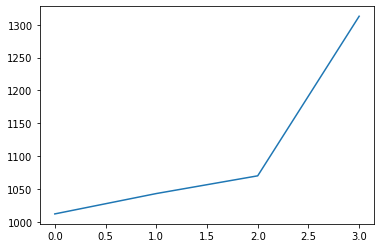

In [6]:
epochs_power = 4
counts = []
for i in [10**j for j in range(epochs_power)]:
    g, (pos_count, _, _) = gmaker(grads, epochs=i, start="zero")
    counts.append(pos_count)
plt.plot(list(range(epochs_power)), counts)

### Testcase 2:
Let's see how this algorithm works on vectors in lower dimensional spaces from the high dimensional space ($R^d$) they belong to.

#### One dimensional subspace:

In [7]:
n, d = 100, 2000

# u1 = np.random.randn(d)
u1 = np.zeros(d)
u2 = np.random.randn(d)

point = lambda t: t*(u2-u1) + u1

vecs = []
for i in range(n):
    vecs.append(point(np.random.randn()))
grads = np.stack(vecs, axis=0)
print(grads.shape)

(100, 2000)


In [8]:
g, _ = gmaker(grads)
print(g.shape)
print(grads@g>=0)

For 100 epochs: 51 out of 100, and maximum of 51
(2000,)
[ True False False  True  True False False  True  True  True False False
 False False False  True  True  True False  True  True  True  True False
  True False False False False  True  True  True  True False False  True
  True False False False False  True  True False  True False False False
  True  True  True  True False False False  True  True  True  True  True
  True False False  True False False False  True False  True  True  True
 False  True False  True False  True False False  True False False  True
 False  True  True  True False  True False  True  True False False False
 False  True  True False]


### Linear subspace with arbitrary dimension $d_{sub}<=d$

In [9]:
n, d = 100, 2000

class PointGenerator():
    def __init__(self, d_sub, d, U=None):
        ### U is the set of vectors as basis of the subspace.
        ### If tuple is passed, then d_sub number of random vectors in R^d
        ### will be generated using `np.random.randn` function.

        self.d_sub = d_sub
        self.d = d
        self.U = U if U is not None else np.random.randn(d_sub, d)
    
    def point(self, w=None):
        w = w if w is not None else np.random.randn(self.d_sub)
        return self.U.T@w
    
    def pt(self, w=None):
        return self.point(w)

In [10]:
pgen = PointGenerator(1, d)

print(pgen.point(np.array([0])))
print(pgen.point())

[0. 0. 0. ... 0. 0. 0.]
[ 0.24923842  0.39306833  0.09766118 ... -0.72101997 -0.08643874
  0.41298991]


In [11]:
poses = []
maxes = []
nums = []
max_dim = 1000

for d_sub in tqdm(range(max_dim)):
    d_sub += 1
    
    pgen = PointGenerator(d_sub, d)
    points = np.stack([pgen.point() for i in range(int(1. * d_sub))], axis=0)
    
    _, (pos_count, max_count, num_pts) = gmaker(points, verbose=0)
    
    poses.append(pos_count)
    maxes.append(max_count)
    nums.append(num_pts)

100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


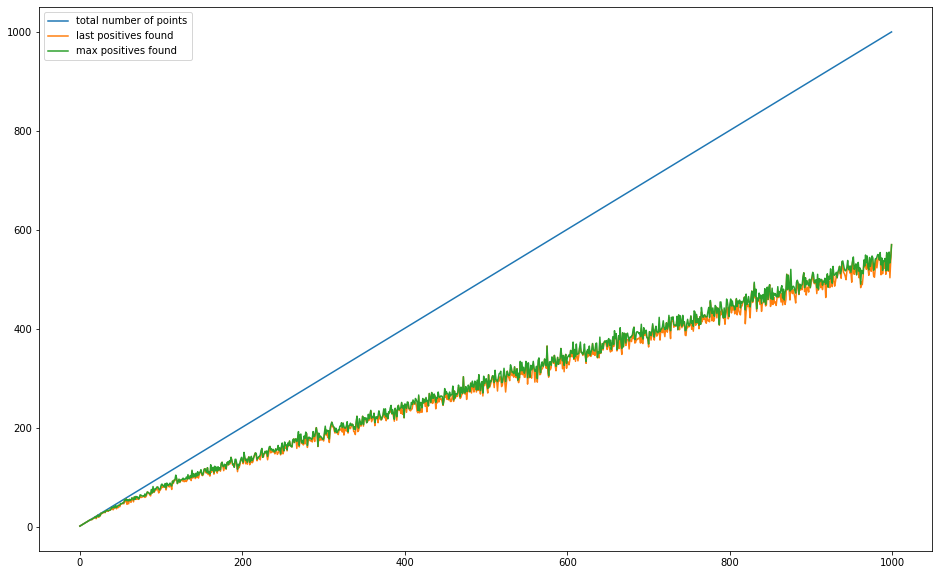

In [12]:
plt.figure(figsize=(16, 10))
plt.plot(list(range(max_dim)), nums, label="total number of points")
plt.plot(list(range(max_dim)), poses, label="last positives found")
plt.plot(list(range(max_dim)), maxes, label="max positives found")
plt.legend()
plt.show()

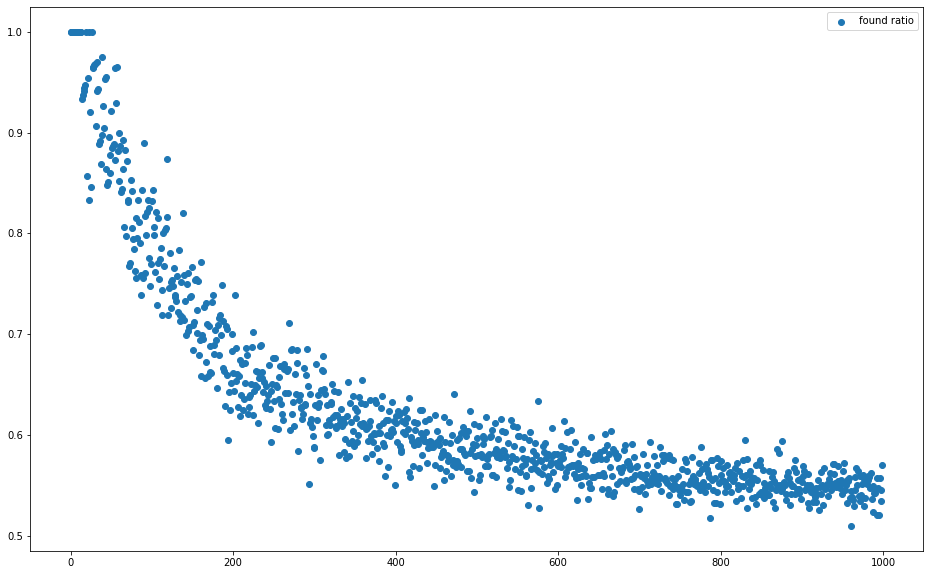

In [13]:
plt.figure(figsize=(16, 10))
# plt.plot(list(range(max_dim)), nums, label="total number of points")
# plt.plot(list(range(max_dim)), poses, label="last positives found")
# plt.plot(list(range(max_dim)), maxes, label="max positives found")
plt.scatter(list(range(max_dim)), np.array(maxes)/np.array(nums), label="found ratio")
plt.legend()
plt.show()